In [26]:
import os

import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
def year_to_day(df: pd.DataFrame, cols=("value_kusd", "volume_tons")) -> pd.DataFrame:
    for col in cols:
        if col in df.columns:
            df[col] /= 365.24
    return df

In [3]:
plt.style.use("bmh")

# read in trade OD matrix

root_dir = ".."

od_dir = os.path.join(root_dir, "results/input/trade_matrix/project-thailand/")
od = year_to_day(pd.read_parquet(os.path.join(od_dir, "trade_nodes_total.parquet")))
print(f"OD has {len(od):,d} flows")

# read in edges and filter out OD flows we certainly can't route to
edges = gpd.read_parquet(os.path.join(root_dir, "results/multi-modal_network/project-thailand/edges.gpq"))
available_destinations = edges[edges["mode"] == "imaginary"].to_id.unique()
available_country_destinations = [d.split("_")[-1] for d in available_destinations if d.startswith("GID_")]

# read nodes to plot where these flows are related to in THA
nodes = gpd.read_parquet(os.path.join(root_dir, "results/multi-modal_network/project-thailand/nodes.gpq"))

OD has 21,431,475 flows


In [42]:
print(f"{od.volume_tons.sum()=}")
print(f"{od.value_kusd.sum()=}")

od.volume_tons.sum()=910599.3023051104
od.value_kusd.sum()=1631323.1622220995


In [4]:
# country boundaries for diagnostic plotting
countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
boundaries = countries.copy()
boundaries.geometry = boundaries.geometry.boundary

In [5]:
country_volume_total = od.loc[:, ["partner_GID_0", "volume_tons"]].groupby("partner_GID_0").sum()
country_volume_total.index.name = "GID_0"

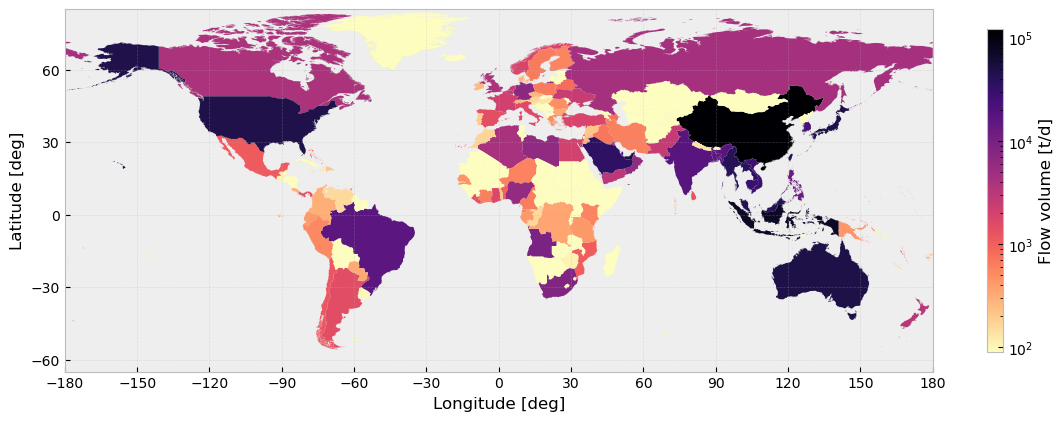

In [19]:
f, ax = plt.subplots(figsize=(14, 7))
to_plot = countries.set_index("GID_0").join(country_volume_total)
cmap = plt.get_cmap("magma_r")
to_plot.plot(
    "volume_tons",
    ax=ax,
    cmap=cmap,
    legend=True,
    norm=matplotlib.colors.LogNorm(
        vmin=to_plot.volume_tons.max(),
        vmax=1E2
    ),
    legend_kwds={
        "shrink": 0.6,
        "label": "Flow volume [t/d]"
    },
)
ax.set_xticks(np.linspace(-180, 180, 13))
ax.set_yticks([-60, -30, 0, 30, 60])
ax.set_ylim(-65, 85)
ax.set_xlim(-180, 180)
ax.grid(alpha=0.3)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
f.savefig("od_countries_log.png")

In [30]:
nodes_with_tonnage.describe()

,volume_tons
count,95251.000000
mean,0.402557
std,3.440449
min,0.000000
25%,0.000000
50%,0.017749
75%,0.166000
max,448.299290


In [39]:
leading_partners = od.loc[:, ["partner_GID_0", "volume_tons"]].groupby("partner_GID_0").sum()\
    .sort_values("volume_tons", ascending=False)[:10].index.values
for iso_a3_code in tqdm(leading_partners):
    node_tonnage = od.loc[od.partner_GID_0==iso_a3_code, ["id", "volume_tons"]].groupby("id").sum()
    node_tonnage.index = node_tonnage.index.to_series().apply(lambda s: f"road_{s}").values
    nodes_with_tonnage = nodes.set_index("id").join(node_tonnage, how="inner")
    nodes_with_tonnage = nodes_with_tonnage[nodes_with_tonnage.volume_tons != 0]
    f, ax = plt.subplots(figsize=(6, 8))
    nodes_with_tonnage.sort_values("volume_tons", ascending=True).plot(
        np.log10(nodes_with_tonnage.volume_tons),
        legend=True,
        ax=ax,
        s=0.1,
        alpha=0.9,
        legend_kwds={"label": "log10(volume)"},
        cmap="Blues",
    )
    ax.set_title(f"Trade with {iso_a3_code}: {nodes_with_tonnage.volume_tons.sum():.1E} tons/d")
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    ax.set_xlim(97, 106)
    ax.set_ylim(5, 21.5)
    f.savefig(f"plots/node_to_partner/{iso_a3_code}.png")
    plt.close(f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.31s/it]


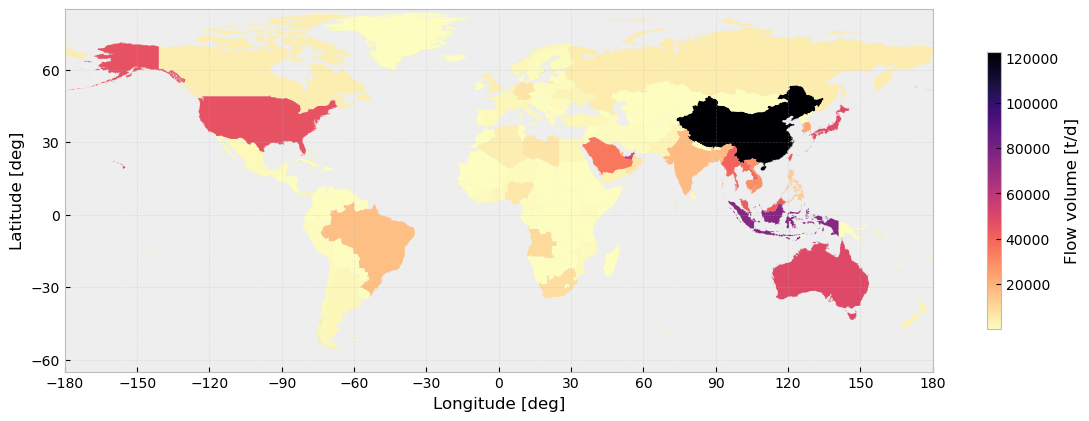

In [23]:
f, ax = plt.subplots(figsize=(14, 6))
to_plot = countries.set_index("GID_0").join(country_volume_total)
cmap = plt.get_cmap("magma_r")
ax.set_xticks(np.linspace(-180, 180, 13))
ax.set_yticks([-60, -30, 0, 30, 60])
ax.set_ylim(-65, 85)
ax.set_xlim(-180, 180)
ax.grid(alpha=0.3)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
to_plot.plot(
    "volume_tons",
    ax=ax,
    cmap=cmap,
    legend=True,
    legend_kwds={
        "shrink": 0.6,
        "label": "Flow volume [t/d]"
    },
)
f.savefig("od_countries_linear.png")

In [ ]:
total_volume_tonnes = od.volume_tons.sum()
by_country = to_plot.loc[:, ["volume_tons"]].copy()
by_country = by_country.sort_values("volume_tons", ascending=False)
by_country = by_country[~by_country.volume_tons.isna()]

# country partnerships required for 90% of trade volume
important_partners = by_country[by_country.volume_tons.cumsum() / total_volume_tonnes < 0.9]
important_partners.head(10)

In [ ]:
important_partners.plot(kind="bar")

In [ ]:
f, ax = plt.subplots()
ax.hist(od.volume_tons.values, bins=np.logspace(-15, 6, 50))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel("Trade volume [t / d]")

In [ ]:
f, ax = plt.subplots()
ax.hist(od.value_kusd.values, bins=np.logspace(-15, 7, 50))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel("Trade value [k$ / d]")

In [ ]:
# original OD has ~21M pairs
# let's drop any pair with a volume of less than x tons
threshold_t = 50
to_plot = od
to_plot = to_plot[to_plot.volume_tons > threshold_t]
print(f"Removing pairs with volume <{threshold_t} tons\n")
print("\tTotal before\tTotal after\tChange")
print(
    f"Volume\t{od.volume_tons.sum():1.2E}"
    f"\t{to_plot.volume_tons.sum():1.2E}"
    f"\t{100 * (to_plot.volume_tons.sum() - od.volume_tons.sum()) / to_plot.volume_tons.sum():1.2f}%"
)
print(
    f"Value\t{od.value_kusd.sum():1.2E}"
    f"\t{to_plot.value_kusd.sum():1.2E}"
    f"\t{100 * (to_plot.value_kusd.sum() - od.value_kusd.sum()) / to_plot.value_kusd.sum():1.2f}%"
)
print(f"\n{len(od)=}")
print(f"{len(to_plot)=}")

In [ ]:
to_plot

In [ ]:
f, ax = plt.subplots()
ax.step(range(len(od)), np.cumsum(od.volume_tons.sort_values()) / np.sum(od.volume_tons))
ax.set_ylabel("Cumulative fraction of trade volume")
ax.set_xlabel("THA road node -> partner country pair")
ax.set_yscale("log")

In [ ]:
f, ax = plt.subplots()
ax.step(range(len(od)), np.cumsum(od.value_kusd.sort_values()) / np.sum(od.value_kusd))
ax.set_ylabel("Cumulative fraction of trade value")
ax.set_xlabel("THA road node -> partner country pair")
ax.set_yscale("log")